In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb


In [3]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_scores/class_Unknown' not in dicto.keys() or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'val_dice_score', 'num_samples_per_epoch']]

    #assert ret_df.shape[0] == 102
    assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [4]:
def proc_pattern_for_eval_result_load(pattern):
    files = glob(pattern)
    listo = []
    for file in files:
        label_num = int(file.split('/')[-1].split('label')[1].split('.pkl')[0])
        
        stuff = pd.read_pickle(file)
        this_list = [label_num, stuff['dice_sensitivity'].item(), stuff['dice_specificity'].item(), stuff['overall_dice'].item()]
        this_arr = np.array(this_list).reshape((1, 4))
        listo.append(this_arr)

        

    combined = np.concatenate(listo, axis = 0)
    df = pd.DataFrame(combined, columns = ['label_number', 'dice_sensitivity', 'dice_specificity', 'overall_dice'])
    df = df.sort_values('label_number').reset_index(drop=True)

    return df

#yolov7s
yolov7 = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_singletask_yolov7_prompted_test_label*.pkl')
yolov7_longer = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_singletask_yolov7_longer_prompted_test_label*.pkl')

#pooled
listo = []
for node in range(8):
    xx = pd.read_pickle(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_pooltask_yolov7_prompted_test_label1_node{node}.pkl')
    for k in xx.keys():
        xx[k] = xx[k].flatten()
    dfo = pd.DataFrame.from_dict(xx)
    listo.append(dfo)
pooled = pd.concat(listo)
pooled = pooled.rename(mapper = {'label_numbers':'label_number'}, axis = 'columns')
pooled = pooled.groupby('label_number').agg({'dice_sensitivity':'mean', 'dice_specificity':'mean', 'overall_dice':'mean'}).reset_index()

# multitask no prompt
multitask = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_multitask_unprompted_test_label1.pkl')
multitask['label_numbers'] = list(range(0,103))
multitask = pd.DataFrame(multitask).loc[1:, :].reset_index(drop=True)
multitask = multitask.rename(mapper = {'label_numbers': 'label_number'}, axis='columns')

#yolov7 pooled 3D
dices_3d = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_3D_pooled_labels_9-4-23/val_dices.npy')
dices_3d = dices_3d[1:].tolist()
label_numbers = list(range(1,103))
pooled_3d = pd.DataFrame({'label_number': label_numbers, 'dice_sensitivity': dices_3d})

# singletask no boxes
#constant_bbox_finetune_df = read_tag_from_wandb(tag = 'constant_bbox', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox')
#singletask_unprompted = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_singletask_yolov7_longer_prompted_test_label*.pkl')

In [10]:
pooled['dice_sensitivity'].quantile(q = 0.025)
print(pooled['dice_sensitivity'].quantile(q = 0.975))
yolov7_longer['dice_sensitivity'].quantile(q = 0.025)
print(yolov7_longer['dice_sensitivity'].quantile(q = 0.975))
print(multitask['dice_sensitivity'].quantile(q = 0.975))

0.8718396872282027
0.8755657732486724
0.7945365011692047


In [7]:
pooled.sort_values('dice_sensitivity')

,label_number,dice_sensitivity,dice_specificity,overall_dice
17,18,0.047620,1.000000,0.984147
32,33,0.324699,0.999427,0.987198
2,3,0.369374,0.998552,0.965560
33,34,0.396741,0.997046,0.904580
18,19,0.405430,0.998226,0.911172
...,...,...,...,...
23,24,0.852163,0.999444,0.963935
4,5,0.859706,0.999263,0.966398
0,1,0.885251,0.998351,0.950430
19,20,0.886820,0.998096,0.950588


In [4]:
print(multitask['dice_sensitivity'].median())
print(yolov7['dice_sensitivity'].median())
print(yolov7_longer['dice_sensitivity'].median())
print(pooled['dice_sensitivity'].median())
#print(pooled_3d['dice_sensitivity'].median())

0.5976549983024597
0.6572133004665375
0.7129665017127991
0.7105649709701538


In [5]:
df_merged = multitask[['label_number', 'dice_sensitivity']].merge(yolov7[['label_number', 'dice_sensitivity']], 
                on='label_number', suffixes = ['_multitask', '_yolov7'], how='inner')

df_merged2 = yolov7_longer[['label_number', 'dice_sensitivity']].merge(pooled[['label_number', 'dice_sensitivity']], 
                on='label_number', suffixes = ['_yolov7_longer', '_pooled'], how='inner')
df_merged = df_merged.merge(df_merged2, on='label_number', how = 'inner')

pooled_3d = pooled_3d.rename(mapper = {'dice_sensitivity':'dice_sensitivity_pooled_3d'}, axis = 'columns')
df_merged = df_merged.merge(pooled_3d, on='label_number', how = 'inner')

df_merged

,label_number,dice_sensitivity_multitask,dice_sensitivity_yolov7,dice_sensitivity_yolov7_longer,dice_sensitivity_pooled,dice_sensitivity_pooled_3d
0,1,8.013906e-01,0.863608,0.886686,0.885251,0.886895
1,2,7.798378e-01,0.822602,0.846060,0.834374,0.822044
2,3,1.315103e-07,0.331286,0.372614,0.369374,0.363103
3,4,5.822296e-01,0.608223,0.696122,0.683714,0.686748
4,5,7.921169e-01,0.854546,0.865505,0.859706,0.854875
...,...,...,...,...,...,...
97,98,5.706789e-01,0.672962,0.719564,0.719795,0.723542
98,99,5.985841e-01,0.675206,0.737202,0.733005,0.741977
99,100,5.824413e-01,0.689044,0.724014,0.723123,0.726841
100,101,5.240251e-01,0.586430,0.646358,0.643936,0.657094


In [17]:
print(df_merged['dice_sensitivity_multitask'].quantile(q=0.95))
print(df_merged['dice_sensitivity_yolov7'].quantile(q=0.95))
print(df_merged['dice_sensitivity_yolov7_longer'].quantile(q=0.95))
print(df_merged['dice_sensitivity_pooled'].quantile(q=0.95))

print(df_merged['dice_sensitivity_multitask'].quantile(q=0.05))
print(df_merged['dice_sensitivity_yolov7'].quantile(q=0.05))
print(df_merged['dice_sensitivity_yolov7_longer'].quantile(q=0.05))
print(df_merged['dice_sensitivity_pooled'].quantile(q=0.05))

0.7906120508909225
0.8317028194665907
0.8512416630983352
0.8440001994371413
7.56154509673479e-08
0.41365052461624147
0.4220216423273087
0.4681243166327477


In [17]:
merged_long = pd.melt(df_merged, id_vars = ['label_number'], 
                    value_vars = ['dice_sensitivity_multitask', 'dice_sensitivity_yolov7', 'dice_sensitivity_yolov7_longer', 'dice_sensitivity_pooled', 'dice_sensitivity_pooled_3d'],
                    var_name = 'method', value_name = 'test_dice_score'
)
mapper = {'dice_sensitivity_pooled': 'pooled', 'dice_sensitivity_yolov7': 'yolov7',
          'dice_sensitivity_multitask': 'multitask', 'dice_sensitivity_yolov7_longer': 'yolov7_longer',
          'dice_sensitivity_pooled_3d': 'pooled_3D'}
merged_long['method'] = merged_long['method'].map(mapper)

merged_long

,label_number,method,test_dice_score
0,1,multitask,8.013906e-01
1,2,multitask,7.798378e-01
2,3,multitask,1.315103e-07
3,4,multitask,5.822296e-01
4,5,multitask,7.921169e-01
...,...,...,...
505,98,pooled_3D,7.235419e-01
506,99,pooled_3D,7.419769e-01
507,100,pooled_3D,7.268407e-01
508,101,pooled_3D,6.570938e-01


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

multitask v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=3.338e-07 stat=-5.716e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=3.056e-08 stat=-6.243e+00
yolov7_longer v.s. pooled: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.629e-01


(<Axes: xlabel='Method', ylabel='Test Dice Score'>,
  <statannot.StatResult.StatResult at 0x2aaba3797670>])

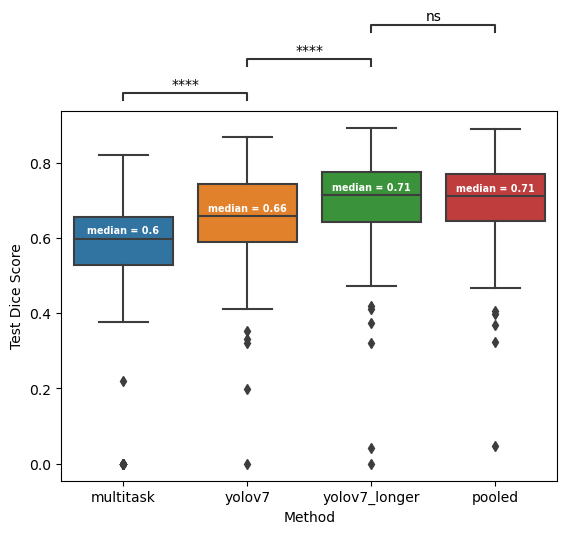

In [18]:
# is there significant difference in how well these methods perform?

order = ['multitask', 'yolov7', 'yolov7_longer', 'pooled']
box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'test_dice_score',
            order = order
)

plt.ylabel('Test Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['test_dice_score'].median().reindex(index = order)
vertical_offset = .02 * merged_long['test_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long, 
    x='method',
    y='test_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1]),
        (order[1], order[2]),
        (order[2], order[3])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

multitask v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=1.902e-07 stat=-5.906e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=1.810e-08 stat=-6.418e+00
yolov7_longer v.s. pooled: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.419e-01
pooled v.s. pooled_3D: t-test paired samples with Bonferroni correction, P_val=1.702e-14 stat=-9.239e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x2aaab4c8b8e0>])

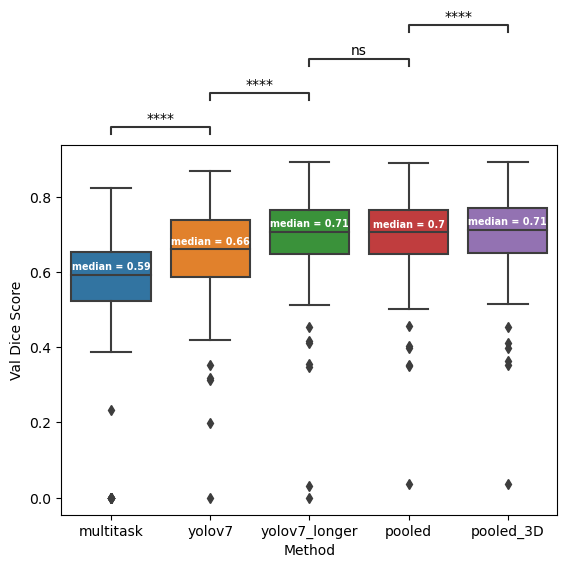

In [24]:
# including pooled 3d
# is there significant difference in how well these methods perform?

order = ['multitask', 'yolov7', 'yolov7_longer', 'pooled', 'pooled_3D']
box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * merged_long['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1]),
        (order[1], order[2]),
        (order[2], order[3]),
        (order[3], order[4])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


### 3D-pooled model performance

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pooled v.s. pooled_3D: t-test paired samples with Bonferroni correction, P_val=4.255e-15 stat=-9.239e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
 [<statannot.StatResult.StatResult at 0x2aab9e10ff70>])

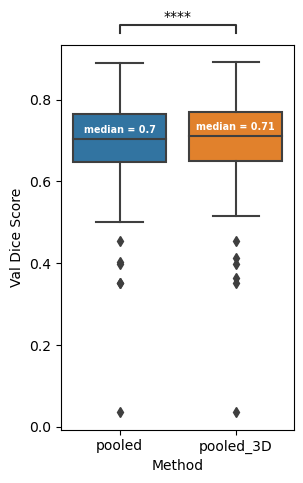

In [34]:
# pooled vs pooled-3D
# is there significant difference in how well these methods perform?

plt.figure(figsize=(3,5))
order = ['pooled', 'pooled_3D']
subset_df = merged_long[merged_long['method'].isin(order)].reset_index(drop=True)
box_plot = sns.boxplot(data = subset_df,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = subset_df.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * subset_df['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=subset_df,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


In [50]:
df_merged

,label_number,dice_sensitivity_multitask,dice_sensitivity_yolov7,dice_sensitivity_yolov7_longer,dice_sensitivity_pooled,dice_sensitivity_pooled_3d
0,1,7.994661e-01,0.862020,0.885881,0.883167,0.886895
1,2,7.696944e-01,0.811639,0.835924,0.820664,0.822044
2,3,1.349329e-07,0.311646,0.354801,0.351988,0.363103
3,4,5.743010e-01,0.599371,0.687716,0.677760,0.686748
4,5,7.807698e-01,0.849339,0.860170,0.854176,0.854875
...,...,...,...,...,...,...
97,98,5.675806e-01,0.667417,0.715483,0.713493,0.723542
98,99,6.003175e-01,0.678250,0.738180,0.729847,0.741977
99,100,5.792221e-01,0.685869,0.722563,0.719753,0.726841
100,101,5.373104e-01,0.594538,0.650480,0.645915,0.657094


Text(9.444444444444445, 0.5, 'Dice Score (Pooled 3D)')

<Figure size 500x500 with 0 Axes>

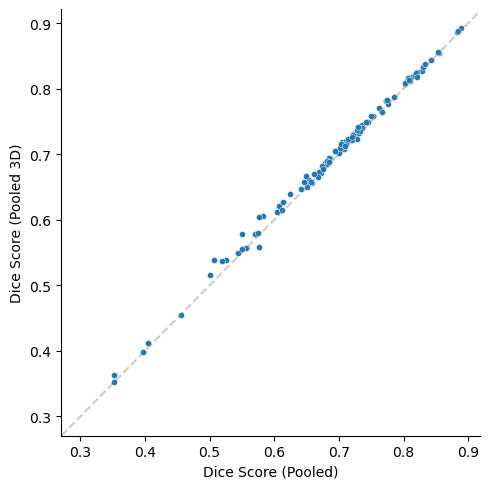

In [54]:
df_merged_tmp = df_merged[df_merged.dice_sensitivity_pooled > 0.2].reset_index(drop=True)
plt.figure(figsize=(5,5))
sns.relplot(df_merged_tmp, x = 'dice_sensitivity_pooled', y = 'dice_sensitivity_pooled_3d', s=20)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (Pooled)')
plt.ylabel('Dice Score (Pooled 3D)')

(102,)